In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'drive/My Drive/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'drive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
#content/drive/My Drive/HAR/UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'drive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [13]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 15
batch_size = 64
n_hidden = 64 

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [17]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


## Single Layer LSTM Model with dropout

In [18]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim), kernel_initializer = 'glorot_uniform'))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [20]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=15)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 23s 3ms/step - loss: 1.4317 - acc: 0.3792 - val_loss: 1.2284 - val_acc: 0.4866
Epoch 2/15
7352/7352 [==============================] - 22s 3ms/step - loss: 1.3023 - acc: 0.4174 - val_loss: 1.3139 - val_acc: 0.4282
Epoch 3/15
7352/7352 [==============================] - 22s 3ms/step - loss: 1.1832 - acc: 0.4973 - val_loss: 1.1295 - val_acc: 0.5572
Epoch 4/15
7352/7352 [==============================] - 22s 3ms/step - loss: 0.9123 - acc: 0.6004 - val_loss: 0.7892 - val_acc: 0.6552
Epoch 5/15
7352/7352 [==============================] - 23s 3ms/step - loss: 0.7439 - acc: 0.6684 - val_loss: 0.7088 - val_acc: 0.6912
Epoch 6/15
7352/7352 [==============================] - 23s 3ms/step - loss: 0.5865 - acc: 0.7497 - val_loss: 0.6336 - val_acc: 0.7581
Epoch 7/15
7352/7352 [==============================] - 22s 3ms/step - loss: 0.5060 - acc: 0.7

In [21]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  1      394  ...                   0                 9
STANDING                 0       94  ...                   0                 0
WALKING                  0        0  ...                  28                17
WALKING_DOWNSTAIRS       0        0  ...                 381                34
WALKING_UPSTAIRS         1        0  ...                  14               374

[6 rows x 6 columns]


In [22]:
score = model.evaluate(X_test, Y_test)
print("Accuracy: %.2f%%" % (score[1]*100))

2947/2947 [==============================] - 6s 2ms/step
Accuracy: 87.28%


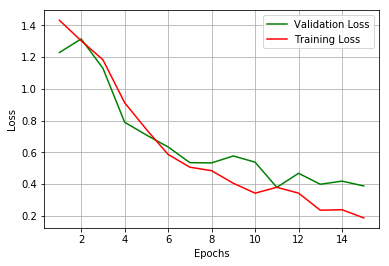

In [24]:

fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,15+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

- - -

## 3 Layers LSTM Model with Dropout

In [21]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True))

#Adding another layer
model.add(LSTM(64, return_sequences=True))  # returns a sequence of vectors of dimension 64

# Adding a dropout layer
model.add(Dropout(0.5))


model.add(LSTM(128))  




# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_8 (LSTM)                (None, 128, 64)           24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 129,798
Trainable params: 129,798
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
import keras
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [25]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=15)

Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 66s 9ms/step - loss: 1.2921 - acc: 0.4124 - val_loss: 1.2404 - val_acc: 0.4910
Epoch 2/15
7352/7352 [==============================] - 66s 9ms/step - loss: 1.2356 - acc: 0.4286 - val_loss: 1.2377 - val_acc: 0.3583
Epoch 3/15
7352/7352 [==============================] - 65s 9ms/step - loss: 1.0627 - acc: 0.5389 - val_loss: 1.1472 - val_acc: 0.5691
Epoch 4/15
7352/7352 [==============================] - 65s 9ms/step - loss: 0.8606 - acc: 0.6353 - val_loss: 0.8955 - val_acc: 0.6590
Epoch 5/15
7352/7352 [==============================] - 66s 9ms/step - loss: 0.6579 - acc: 0.6976 - val_loss: 0.6622 - val_acc: 0.7085
Epoch 6/15
7352/7352 [==============================] - 66s 9ms/step - loss: 0.5128 - acc: 0.7633 - val_loss: 0.5733 - val_acc: 0.7536
Epoch 7/15
7352/7352 [==============================] - 65s 9ms/step - loss: 0.4824 - acc: 0.7983 - val_loss: 0.5050 - val_acc: 0.8110
Epoch 8

In [26]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 528        0  ...                   9                 0
SITTING                  1      421  ...                   1                 3
STANDING                 0      131  ...                   0                 0
WALKING                  0        0  ...                   7                28
WALKING_DOWNSTAIRS       0        0  ...                 401                19
WALKING_UPSTAIRS         0        0  ...                  17               428

[6 rows x 6 columns]


In [27]:
score = model.evaluate(X_test, Y_test)
print("Accuracy: %.2f%%" % (score[1]*100))

2947/2947 [==============================] - 18s 6ms/step
Accuracy: 89.41%


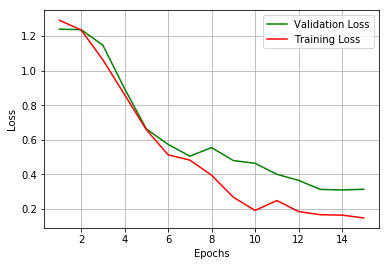

In [28]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,15+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

- - -

## 2 Layer LSTM Model with Dropout and Batch Normalization

In [0]:
from keras.layers.normalization import BatchNormalization

model = Sequential()

model.add(LSTM(32, return_sequences=True,kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(64,kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='softmax'))
#model.summary()

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=15)

Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 178s 24ms/step - loss: 0.0954 - acc: 0.9668 - val_loss: 0.1048 - val_acc: 0.9577
Epoch 2/15
7352/7352 [==============================] - 176s 24ms/step - loss: 0.0729 - acc: 0.9730 - val_loss: 0.0805 - val_acc: 0.9682
Epoch 3/15
7352/7352 [==============================] - 175s 24ms/step - loss: 0.0645 - acc: 0.9757 - val_loss: 0.0842 - val_acc: 0.9704
Epoch 4/15
7352/7352 [==============================] - 174s 24ms/step - loss: 0.0623 - acc: 0.9768 - val_loss: 0.0902 - val_acc: 0.9643
Epoch 5/15
7352/7352 [==============================] - 174s 24ms/step - loss: 0.0512 - acc: 0.9803 - val_loss: 0.0813 - val_acc: 0.9691
Epoch 6/15
7352/7352 [==============================] - 174s 24ms/step - loss: 0.0526 - acc: 0.9792 - val_loss: 0.0863 - val_acc: 0.9680
Epoch 7/15
7352/7352 [==============================] - 174s 24ms/step - loss: 0.0459 - acc: 0.9810 - val_loss: 0.0807 - val_acc: 

In [0]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

2947/2947 [==============================] - 12s 4ms/step
Accuracy: 96.35%


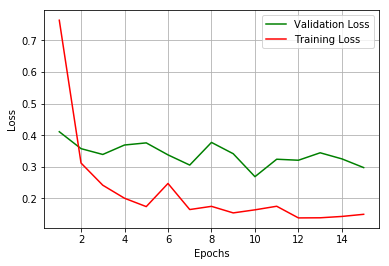

In [33]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epochs') ; ax.set_ylabel('Loss')

# list of epoch numbers
list_of_epoch = list(range(1,15+1))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

ax.plot(list_of_epoch, val_loss, 'g', label="Validation Loss")
ax.plot(list_of_epoch, train_loss, 'r', label="Training Loss")
plt.legend()
plt.grid()
plt.show();

# Conclusion
 - The use of simply a  2 Layer LSTM model with Batch Normalization and Dropout rate of 0.5 gives 96.35% accuracy which is comparable to those of the best performing ML models.

In [34]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Number of Layers", "BN","Dropout", "Accuracy"]

x.add_row(["1", 'NO',0.5, '87.28%'])
x.add_row(["3", 'NO',0.5, '89.41%'])
x.add_row(["2", 'YES',0.5, '96.35%'])


print(x)

+------------------+-----+---------+----------+
| Number of Layers |  BN | Dropout | Accuracy |
+------------------+-----+---------+----------+
|        1         |  NO |   0.5   |  87.28%  |
|        3         |  NO |   0.5   |  89.41%  |
|        2         | YES |   0.5   |  96.35%  |
+------------------+-----+---------+----------+
